# Stomach Tumor Segmentation Model - Prediction & Evaluation

This notebook evaluates the trained DeepLabV3+ model for stomach tumor region segmentation.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
from glob import glob
from tqdm import tqdm
import os
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

try:
    import seaborn as sns
except:
    print("seaborn not available, using matplotlib only.")
    sns = None

# Device setup
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/user/anaconda3/envs/urban/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:1


In [ ]:
# Configuration
batch_size = 2
img_size = 512
class_list = [
    "Background",
    "Stroma",
    "Non_Tumor",
    "Tumor",
]

# Paths
img_path = '../../data/NIPA/integrated_512/stomach/images/'
model_path = '../../model/Tumor_region_segmentation/stomach/ST_callback.pt'

# Color map for visualization
color_map = {
    0: (255, 255, 255),  # Background - White
    1: (0, 255, 0),      # Stroma - Green
    2: (0, 0, 255),      # Non_Tumor - Blue
    3: (255, 255, 0),    # Tumor - Yellow
}

tf = ToTensor()

## 1. Data Loading

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image = self.img_path[idx]
        label = self.label[idx]
        return image, label

In [ ]:
# Load image and mask paths
img_list = glob(img_path + '*.jpeg')
mask_list = [i.replace('/images/', '/masks/') for i in img_list]
mask_list = [i.replace('.jpeg', '.npy') for i in mask_list]

# Train/Test split (same random_state as training)
train_img_list, test_img_list, train_mask_list, test_mask_list = train_test_split(
    img_list, mask_list, test_size=0.2, random_state=41
)

print(f"Total images: {len(img_list)}")
print(f"Train images: {len(train_img_list)}")
print(f"Test images: {len(test_img_list)}")

Total images: 5341
Train images: 4272
Test images: 1069


In [ ]:
# Load test data into memory
print("Loading test data...")
test_img_resource_list = torch.zeros((len(test_img_list), 3, img_size, img_size))
test_mask_resource_list = torch.zeros((len(test_img_list), len(class_list), img_size, img_size))

for i in tqdm(range(len(test_img_list))):
    image = tf(Image.open(test_img_list[i]).resize((img_size, img_size)))
    mask = torch.from_numpy(np.load(test_mask_list[i])).float()
    mask = mask.permute(2, 0, 1)
    test_img_resource_list[i] = image
    test_mask_resource_list[i] = mask

test_dataset = CustomDataset(test_img_resource_list, test_mask_resource_list)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test dataloader batches: {len(test_dataloader)}")

Loading test data...


100%|██████████| 1069/1069 [04:00<00:00,  4.44it/s]

Test dataset size: 1069
Test dataloader batches: 535


## 2. Model Loading

In [ ]:
# Initialize model
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b5",
    encoder_weights=None,
    in_channels=3,
    classes=len(class_list),
).to(device)

# Load trained weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Model loaded from: {model_path}")

Model loaded from: ../../model/Tumor_region_segmentation/stomach/ST_callback.pt


## 3. Sample Prediction Visualization

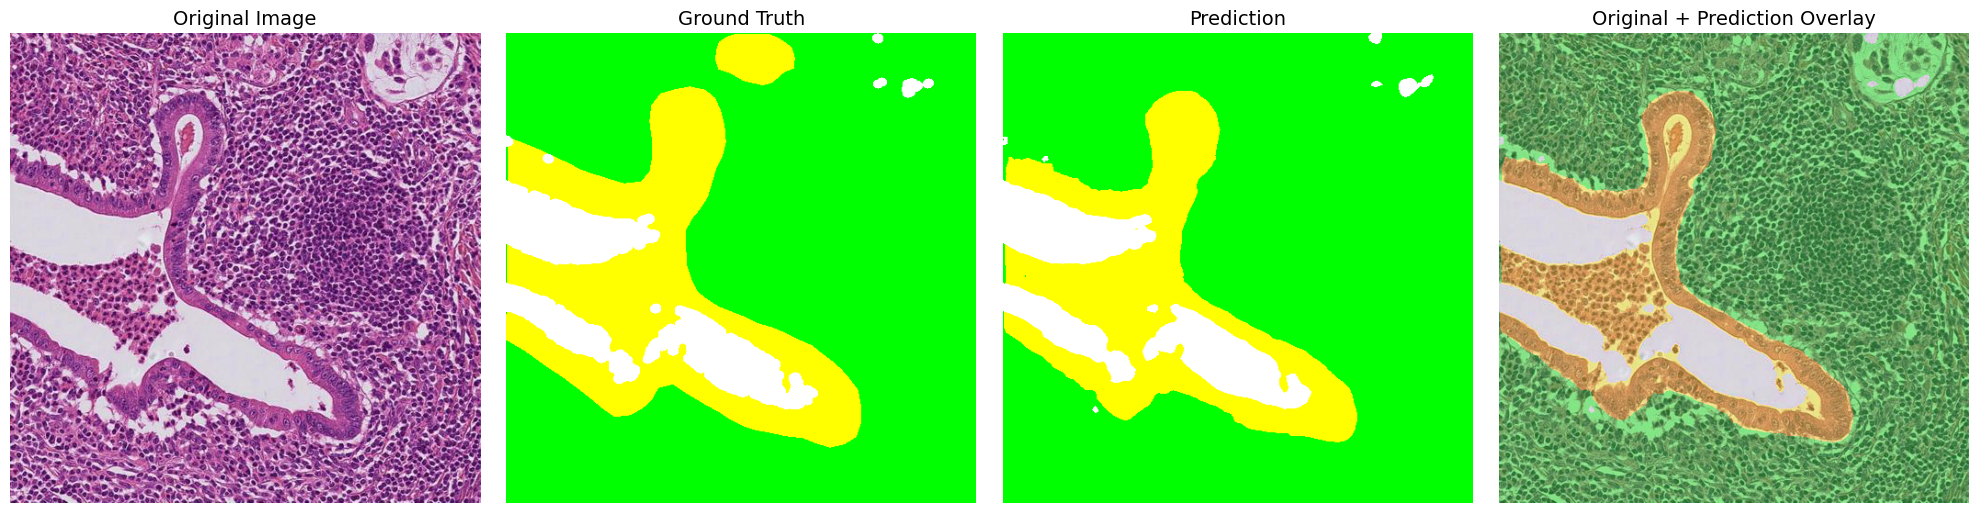

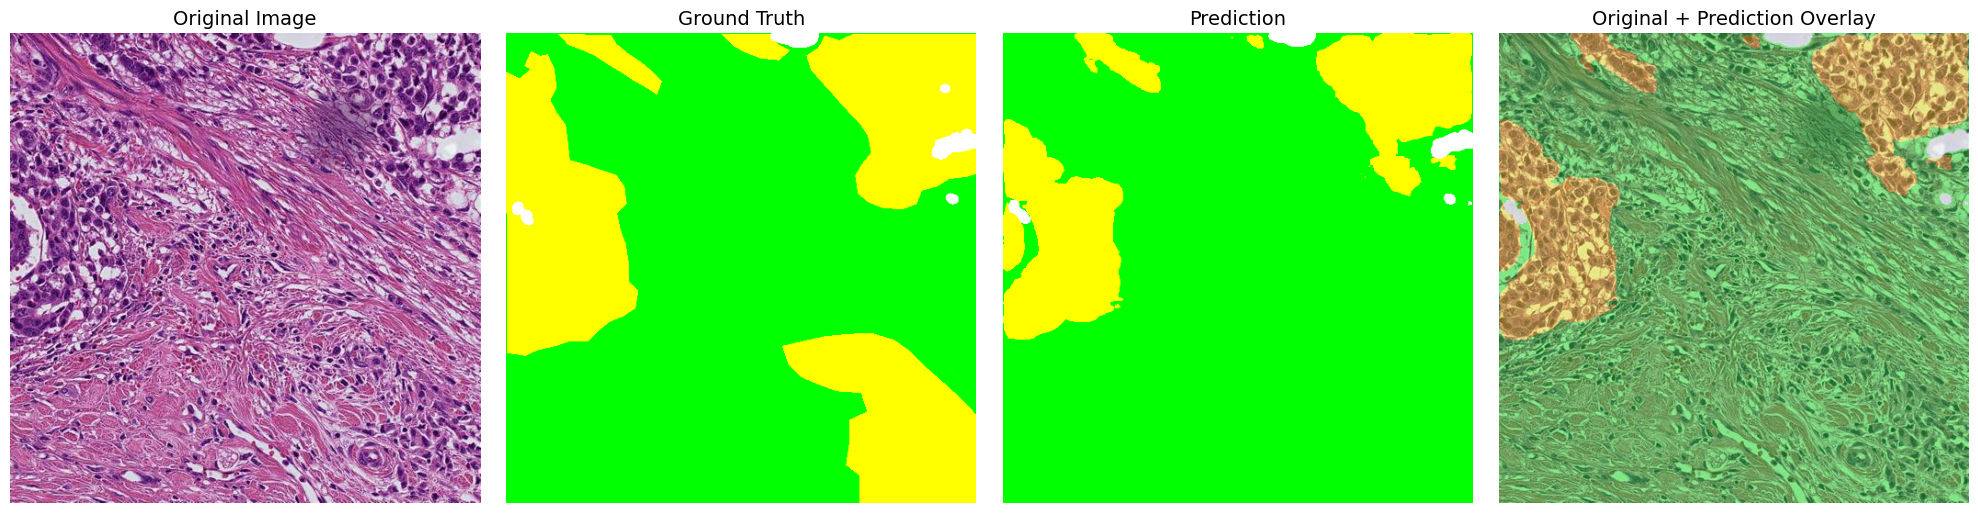

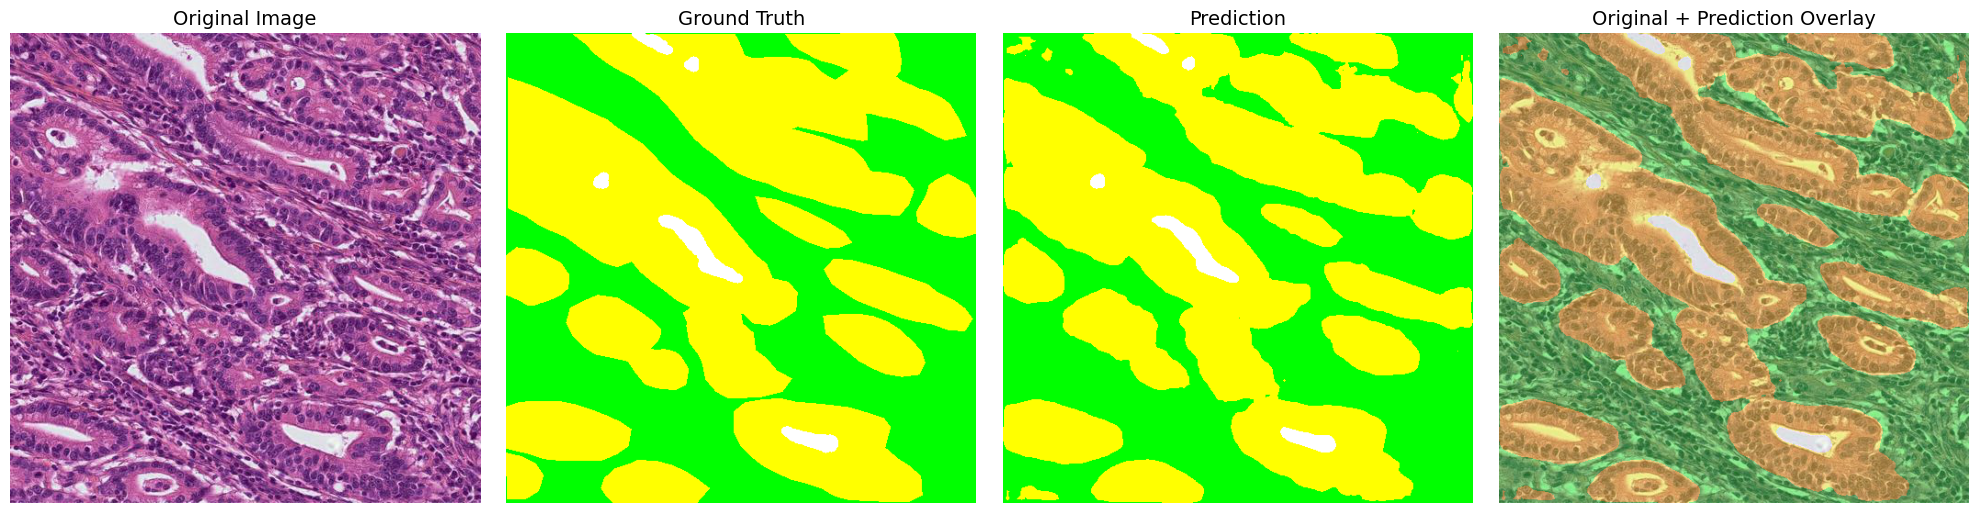

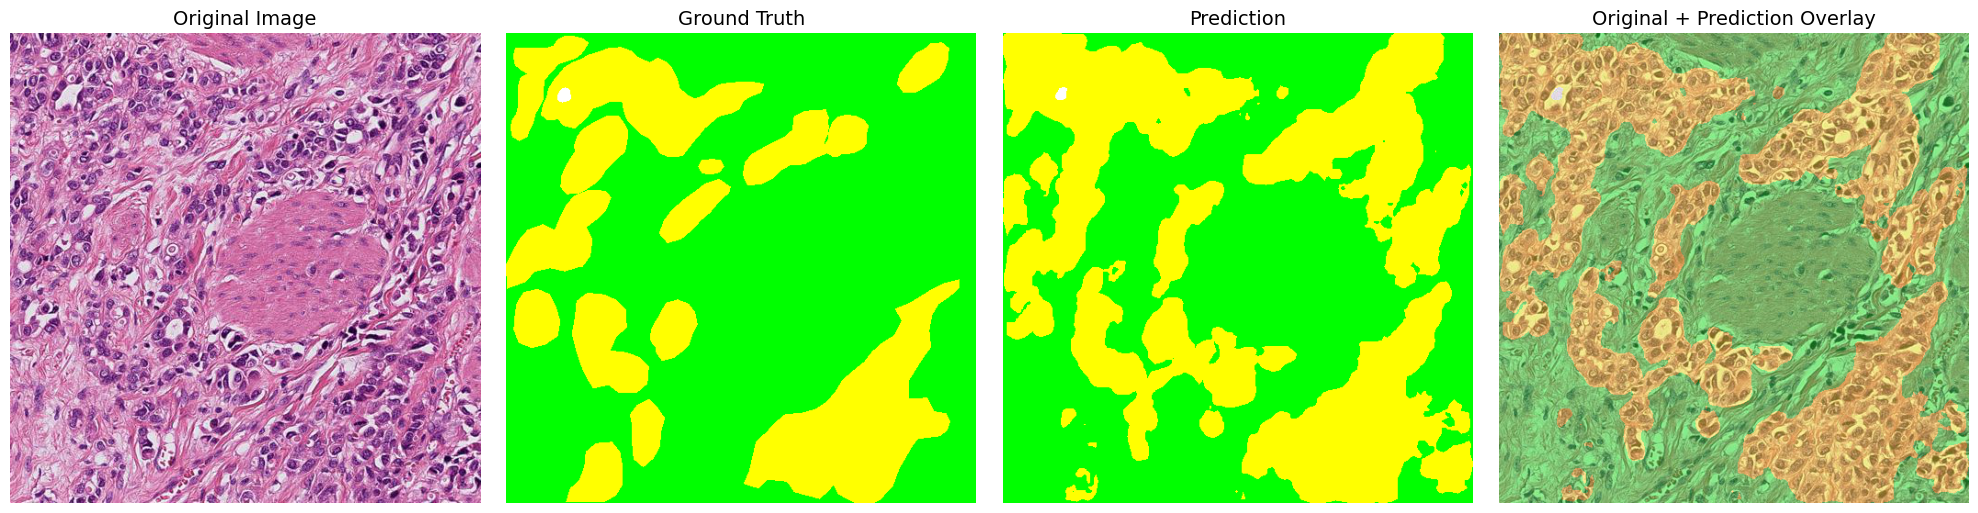

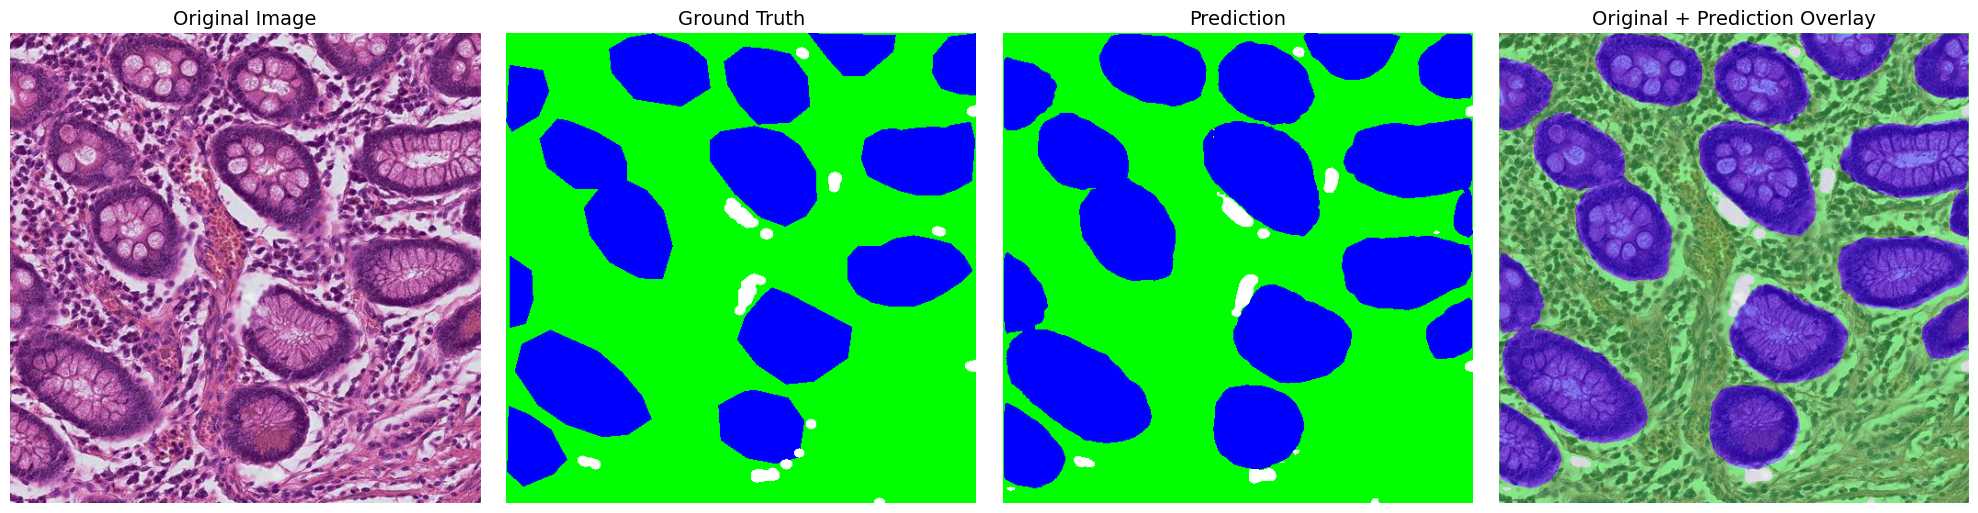

In [ ]:
def visualize_prediction(model, dataloader, num_samples=3):
    """Visualize sample predictions"""
    model.eval()
    
    with torch.no_grad():
        test_iter = iter(dataloader)
        
        for sample_idx in range(num_samples):
            try:
                x_test, y_test = next(test_iter)
            except StopIteration:
                break
            
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).float()
            
            predict = model(x_test)
            predict_softmax = F.softmax(predict, dim=1)
            predict_argmax = torch.argmax(predict_softmax, dim=1)
            
            x_test_np = x_test.cpu().numpy()
            y_test_np = y_test.cpu().numpy()
            predict_np = predict_argmax.cpu().numpy()
            
            batch_idx = 0
            original_img = np.transpose(x_test_np[batch_idx], (1, 2, 0))
            
            # Ground Truth mask
            gt_mask_rgb = np.zeros((img_size, img_size, 3), dtype=np.uint8)
            gt_argmax = np.argmax(y_test_np[batch_idx], axis=0)
            for class_idx, color in color_map.items():
                gt_mask_rgb[gt_argmax == class_idx] = color
            
            # Prediction mask
            pred_mask_rgb = np.zeros((img_size, img_size, 3), dtype=np.uint8)
            for class_idx, color in color_map.items():
                pred_mask_rgb[predict_np[batch_idx] == class_idx] = color
            
            # Overlay
            alpha = 0.4
            overlay_img = (original_img * 255).astype(np.uint8).copy()
            for class_idx, color in color_map.items():
                if class_idx == 0:
                    continue
                mask_area = (predict_np[batch_idx] == class_idx)
                if mask_area.any():
                    color_array = np.array(color, dtype=np.uint8)
                    overlay_img[mask_area] = ((1 - alpha) * overlay_img[mask_area] + alpha * color_array).astype(np.uint8)
            
            # Plot
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            axes[0].imshow(original_img)
            axes[0].set_title('Original Image', fontsize=14)
            axes[0].axis('off')
            
            axes[1].imshow(gt_mask_rgb)
            axes[1].set_title('Ground Truth', fontsize=14)
            axes[1].axis('off')
            
            axes[2].imshow(pred_mask_rgb)
            axes[2].set_title('Prediction', fontsize=14)
            axes[2].axis('off')
            
            axes[3].imshow(overlay_img)
            axes[3].set_title('Original + Prediction Overlay', fontsize=14)
            axes[3].axis('off')
            
            plt.tight_layout()
            plt.show()

visualize_prediction(model, test_dataloader, num_samples=5)

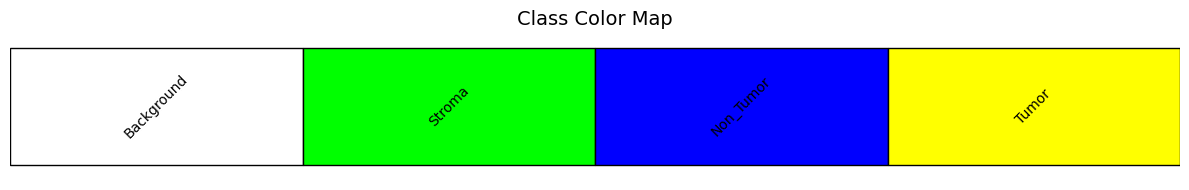

In [ ]:
# Show color legend
plt.figure(figsize=(12, 2))
for i, (class_idx, color) in enumerate(color_map.items()):
    plt.barh(0, 1, left=i, color=np.array(color)/255.0, edgecolor='black')
    plt.text(i+0.5, 0, class_list[class_idx], ha='center', va='center', 
            rotation=45, fontsize=10)

plt.xlim(0, len(color_map))
plt.ylim(-0.5, 0.5)
plt.title('Class Color Map', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Performance Evaluation

In [ ]:
def calculate_dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def calculate_iou(pred, target, smooth=1e-6):
    """Calculate IoU (Jaccard Index)"""
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def calculate_95_ci(data):
    """Calculate 95% confidence interval"""
    mean = np.mean(data)
    if len(data) > 1:
        se = stats.sem(data)
        ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=se)
    else:
        ci = (mean, mean)
    return mean, ci

In [ ]:
# Full test set evaluation
model.eval()
all_predictions = []
all_targets = []
all_dice_scores = {i: [] for i in range(len(class_list))}
all_iou_scores = {i: [] for i in range(len(class_list))}
pixel_accuracies = []

print("Evaluating on test set...")
with torch.no_grad():
    for batch_idx_eval, (x_test_eval, y_test_eval) in enumerate(tqdm(test_dataloader)):
        x_test_eval = x_test_eval.to(device).float()
        y_test_eval = y_test_eval.to(device).float()
        
        predict_eval = model(x_test_eval)
        predict_softmax_eval = F.softmax(predict_eval, dim=1)
        predict_argmax_eval = torch.argmax(predict_softmax_eval, dim=1)
        
        y_test_eval_np = y_test_eval.cpu().numpy()
        predict_eval_np = predict_argmax_eval.cpu().numpy()
        
        for i in range(predict_eval_np.shape[0]):
            y_true = np.argmax(y_test_eval_np[i], axis=0)
            y_pred = predict_eval_np[i]
            
            all_predictions.extend(y_pred.flatten())
            all_targets.extend(y_true.flatten())
            
            pixel_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
            pixel_accuracies.append(pixel_acc)
            
            for class_idx in range(len(class_list)):
                y_true_class = (y_true == class_idx).astype(np.float32)
                y_pred_class = (y_pred == class_idx).astype(np.float32)
                
                dice = calculate_dice_coefficient(y_pred_class, y_true_class)
                iou = calculate_iou(y_pred_class, y_true_class)
                
                all_dice_scores[class_idx].append(dice)
                all_iou_scores[class_idx].append(iou)

print("Evaluation complete!")

Evaluating on test set...


100%|██████████| 535/535 [00:36<00:00, 14.86it/s]

Evaluation complete!


In [ ]:
# Print results
print("\n" + "="*80)
print("STOMACH TUMOR SEGMENTATION - TEST SET PERFORMANCE EVALUATION")
print("="*80)

# 1. Pixel Accuracy
pixel_acc_mean, pixel_acc_ci = calculate_95_ci(pixel_accuracies)
print(f"\n1. Pixel Accuracy:")
print(f"   Mean ± Std: {pixel_acc_mean:.4f} ± {np.std(pixel_accuracies):.4f}")
print(f"   95% CI: [{pixel_acc_ci[0]:.4f}, {pixel_acc_ci[1]:.4f}]")
print(f"   Min: {np.min(pixel_accuracies):.4f}, Max: {np.max(pixel_accuracies):.4f}")

# 2. Dice Score per Class
print(f"\n2. Dice Score per Class:")
print(f"{'Class':<15} {'Mean':<10} {'Std':<10} {'95% CI':<25} {'Min':<10} {'Max':<10}")
print("-" * 80)

dice_means = []
for class_idx in range(len(class_list)):
    dice_mean, dice_ci = calculate_95_ci(all_dice_scores[class_idx])
    dice_std = np.std(all_dice_scores[class_idx])
    dice_min = np.min(all_dice_scores[class_idx])
    dice_max = np.max(all_dice_scores[class_idx])
    dice_means.append(dice_mean)
    
    print(f"{class_list[class_idx]:<15} {dice_mean:<10.4f} {dice_std:<10.4f} [{dice_ci[0]:.4f}, {dice_ci[1]:.4f}]  {dice_min:<10.4f} {dice_max:<10.4f}")

overall_dice_mean = np.mean(dice_means)
overall_dice_std = np.std(dice_means)
print(f"\nMean Dice Score (mDSC): {overall_dice_mean:.4f} ± {overall_dice_std:.4f}")

# 3. IoU per Class
print(f"\n3. IoU (Jaccard Index) per Class:")
print(f"{'Class':<15} {'Mean':<10} {'Std':<10} {'95% CI':<25} {'Min':<10} {'Max':<10}")
print("-" * 80)

iou_means = []
for class_idx in range(len(class_list)):
    iou_mean, iou_ci = calculate_95_ci(all_iou_scores[class_idx])
    iou_std = np.std(all_iou_scores[class_idx])
    iou_min = np.min(all_iou_scores[class_idx])
    iou_max = np.max(all_iou_scores[class_idx])
    iou_means.append(iou_mean)
    
    print(f"{class_list[class_idx]:<15} {iou_mean:<10.4f} {iou_std:<10.4f} [{iou_ci[0]:.4f}, {iou_ci[1]:.4f}]  {iou_min:<10.4f} {iou_max:<10.4f}")

overall_iou_mean = np.mean(iou_means)
overall_iou_std = np.std(iou_means)
print(f"\nMean IoU (mIoU): {overall_iou_mean:.4f} ± {overall_iou_std:.4f}")


STOMACH TUMOR SEGMENTATION - TEST SET PERFORMANCE EVALUATION

1. Pixel Accuracy:
   Mean ± Std: 0.9065 ± 0.0685
   95% CI: [0.9023, 0.9106]
   Min: 0.3937, Max: 0.9989

2. Dice Score per Class:
Class           Mean       Std        95% CI                    Min        Max       
--------------------------------------------------------------------------------
Background      0.8525     0.1259     [0.8450, 0.8601]  0.0000     1.0000    
Stroma          0.9041     0.1048     [0.8978, 0.9104]  0.0661     0.9994    
Non_Tumor       0.9321     0.1958     [0.9203, 0.9438]  0.0000     1.0000    
Tumor           0.7251     0.3315     [0.7052, 0.7450]  0.0000     1.0000    

Mean Dice Score (mDSC): 0.8534 ± 0.0794

3. IoU (Jaccard Index) per Class:
Class           Mean       Std        95% CI                    Min        Max       
--------------------------------------------------------------------------------
Background      0.7599     0.1581     [0.7505, 0.7694]  0.0000     1.0000    
Strom


4. Confusion Matrix:


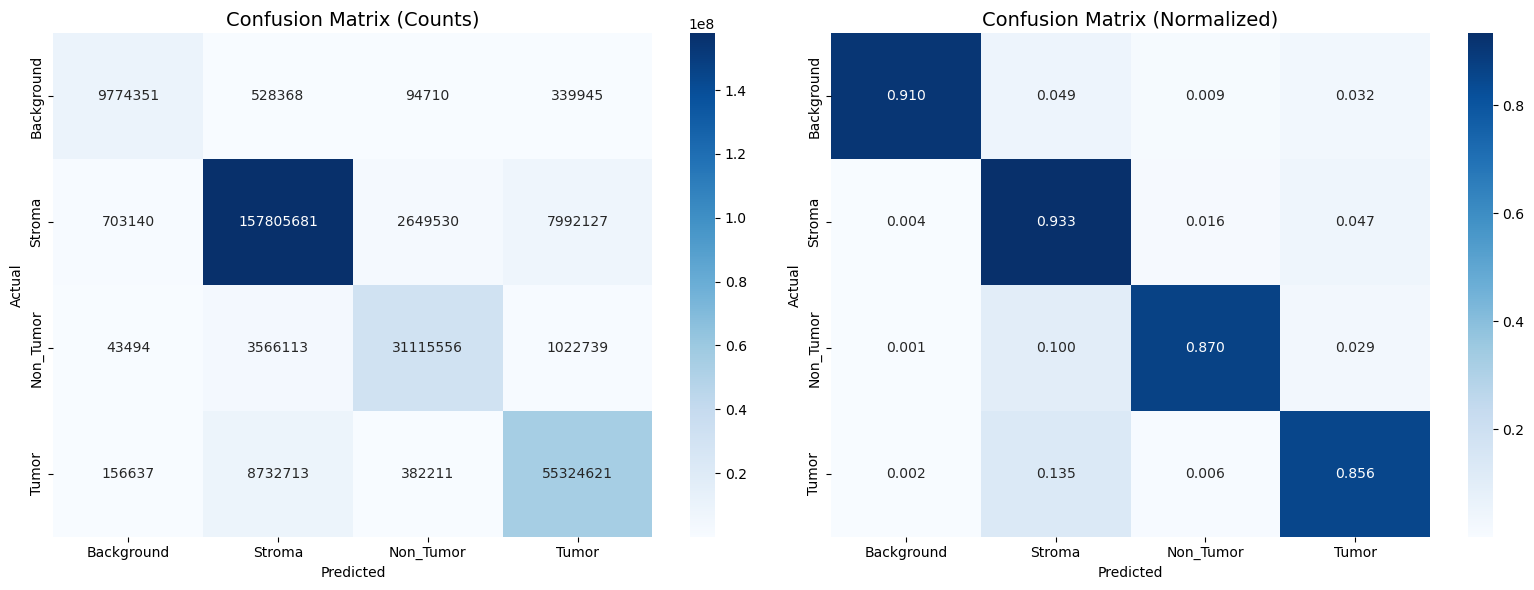

In [ ]:
# Confusion Matrix
print("\n4. Confusion Matrix:")
cm = confusion_matrix(all_targets, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
if sns:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_list, yticklabels=class_list, ax=axes[0])
else:
    im = axes[0].imshow(cm, cmap='Blues')
    for i in range(len(class_list)):
        for j in range(len(class_list)):
            axes[0].text(j, i, f'{cm[i, j]}', ha='center', va='center')
    axes[0].set_xticks(range(len(class_list)))
    axes[0].set_yticks(range(len(class_list)))
    axes[0].set_xticklabels(class_list, rotation=45)
    axes[0].set_yticklabels(class_list)
    plt.colorbar(im, ax=axes[0])

axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized
if sns:
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_list, yticklabels=class_list, ax=axes[1])
else:
    im = axes[1].imshow(cm_normalized, cmap='Blues')
    for i in range(len(class_list)):
        for j in range(len(class_list)):
            axes[1].text(j, i, f'{cm_normalized[i, j]:.3f}', ha='center', va='center')
    axes[1].set_xticks(range(len(class_list)))
    axes[1].set_yticks(range(len(class_list)))
    axes[1].set_xticklabels(class_list, rotation=45)
    axes[1].set_yticklabels(class_list)
    plt.colorbar(im, ax=axes[1])

axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
# Classification Report
print("\n5. Classification Report (Pixel-level):")
print(classification_report(all_targets, all_predictions, target_names=class_list, digits=4))


5. Classification Report (Pixel-level):
              precision    recall  f1-score   support

  Background     0.9154    0.9103    0.9129  10737374
      Stroma     0.9248    0.9329    0.9289 169150478
   Non_Tumor     0.9087    0.8704    0.8891  35747902
       Tumor     0.8554    0.8565    0.8559  64596182

    accuracy                         0.9065 280231936
   macro avg     0.9011    0.8925    0.8967 280231936
weighted avg     0.9064    0.9065    0.9064 280231936



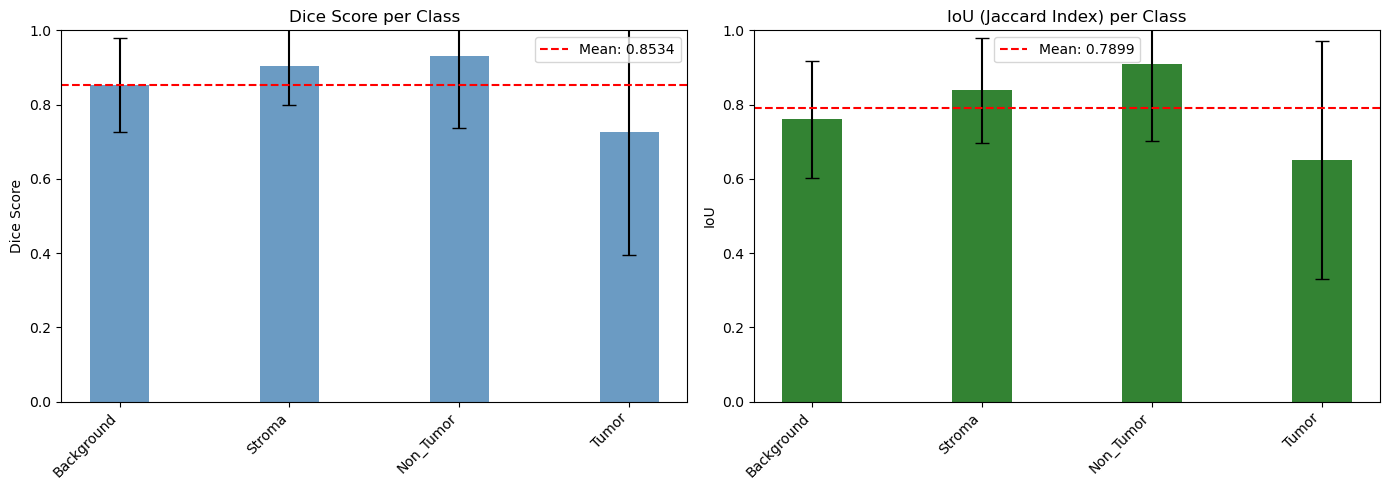

In [ ]:
# Visualize metrics per class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(class_list))
width = 0.35

# Dice scores
dice_stds = [np.std(all_dice_scores[i]) for i in range(len(class_list))]
axes[0].bar(x, dice_means, width, yerr=dice_stds, capsize=5, color='steelblue', alpha=0.8)
axes[0].set_ylabel('Dice Score')
axes[0].set_title('Dice Score per Class')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_list, rotation=45, ha='right')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=overall_dice_mean, color='r', linestyle='--', label=f'Mean: {overall_dice_mean:.4f}')
axes[0].legend()

# IoU scores
iou_stds = [np.std(all_iou_scores[i]) for i in range(len(class_list))]
axes[1].bar(x, iou_means, width, yerr=iou_stds, capsize=5, color='darkgreen', alpha=0.8)
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU (Jaccard Index) per Class')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_list, rotation=45, ha='right')
axes[1].set_ylim([0, 1])
axes[1].axhline(y=overall_iou_mean, color='r', linestyle='--', label=f'Mean: {overall_iou_mean:.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Summary

In [ ]:
# Summary table
print("\n" + "="*80)
print("SUMMARY - STOMACH TUMOR SEGMENTATION MODEL")
print("="*80)
print(f"\nModel: DeepLabV3+ with EfficientNet-B5 encoder")
print(f"Image Size: {img_size}x{img_size}")
print(f"Number of Classes: {len(class_list)}")
print(f"Test Set Size: {len(test_dataset)} images")
print(f"\n{'Metric':<25} {'Value':<15}")
print("-" * 40)
print(f"{'Pixel Accuracy':<25} {pixel_acc_mean:.4f} ± {np.std(pixel_accuracies):.4f}")
print(f"{'Mean Dice Score (mDSC)':<25} {overall_dice_mean:.4f} ± {overall_dice_std:.4f}")
print(f"{'Mean IoU (mIoU)':<25} {overall_iou_mean:.4f} ± {overall_iou_std:.4f}")
print("\nClass-wise Dice Scores:")
for i, class_name in enumerate(class_list):
    print(f"  {class_name:<20} {dice_means[i]:.4f}")
print("="*80)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.

SUMMARY - STOMACH TUMOR SEGMENTATION MODEL

Model: DeepLabV3+ with EfficientNet-B5 encoder
Image Size: 512x512
Number of Classes: 4
Test Set Size: 1069 images

Metric                    Value          
----------------------------------------
Pixel Accuracy            0.9065 ± 0.0685
Mean Dice Score (mDSC)    0.8534 ± 0.0794
Mean IoU (mIoU)           0.7899 ± 0.0963

Class-wise Dice Scores:
  Background           0.8525
  Stroma               0.9041
  Non_Tumor            0.9321
  Tumor                0.7251
